In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
import os
from torchvision import transforms
import torch.nn as nn
from torch import optim
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter

In [ ]:
!unzip -q /content/drive/MyDrive/CC/datasets/Set1_ground_truth_images_wo_CC.zip -d Set1_ground_truth_images_wo_CC
!unzip -q /content/drive/MyDrive/CC/datasets/Set1_input_images_wo_CC_JPG.zip -d Set1_input_images_wo_CC_JPG

In [ ]:
CHECKPOINTS = '/content/drive/MyDrive/CC/checkpoints'
IN_DIR = '/content/Set1_input_images_wo_CC_JPG'
GT_DIR = '/content/Set1_ground_truth_images_wo_CC'
FOLD_DIR = '/content/drive/MyDrive/CC/datasets/Set1_folds'

# Data

In [ ]:
class RendererWB(Dataset):
    def __init__(self, train=True, transform=None):
        self.img_dir = IN_DIR
        self.gt_dir = GT_DIR
        fold_base = FOLD_DIR

        # Get imgs from folds
        if train == True:
            folds = ['fold_2.txt', 'fold_3.txt']
        else:
            folds = ['fold_1.txt']

        self.imgs = []
        for fold in folds:
            with open(os.path.join(fold_base, fold), 'r') as f:
                self.imgs += [s.strip().split(".")[0] for s in f.readlines()]

        self.transform = transform

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, index):
        # Get file names
        img_fn = self.imgs[index]
        in_img_fn = os.path.join(self.img_dir, img_fn + '.jpg')
        gt_img_fn = os.path.join(self.gt_dir, img_fn.rsplit('_', maxsplit=2)[0] + '_G_AS.png')

        # Read img
        in_img = read_image(in_img_fn) / 255
        gt_img = read_image(gt_img_fn) / 255
        
        # Transform
        combine_img = torch.cat((in_img, gt_img), dim=0)
        combine_img = self.transform(combine_img)
        in_img = combine_img[:3,...]
        gt_img = combine_img[3:,...]

        return in_img.to(torch.float32), gt_img.to(torch.float32)

mytransform = transforms.Compose([
    transforms.Resize((320, 320)),
    transforms.RandomCrop((256, 256)),
    transforms.RandomHorizontalFlip(0.5)
])

train_dataset = RendererWB(train=True, transform=mytransform)
test_dataset = RendererWB(train=False, transform=mytransform)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=8)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=8)

## Show dataset

Input


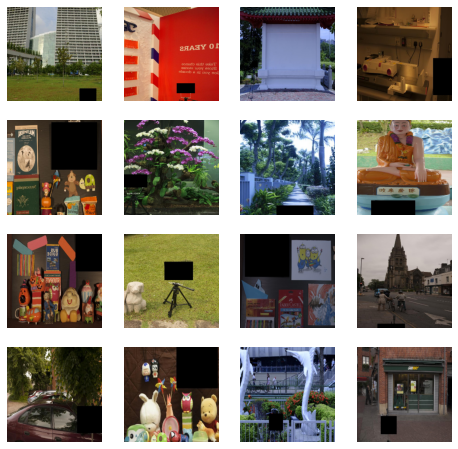

In [ ]:
def show(image):
    image = torch.permute(image, (1,2,0))
    plt.imshow(image)
    plt.axis("off")

input_images, target_images = next(iter(train_dataloader))

print("Input")
plt.figure(figsize=(8,8))
for i in range(16):
    plt.subplot(4, 4, i+1)
    show(input_images[i])

Target


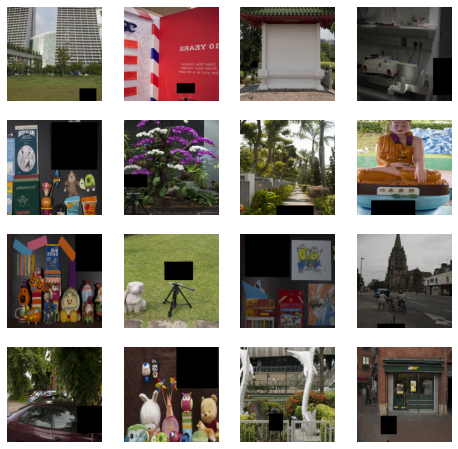

In [ ]:
print("Target")
plt.figure(figsize=(8,8))
for i in range(16):
    plt.subplot(4, 4, i+1)
    show(target_images[i])

# Simple Color Mapping Network

In [ ]:
class ConvBlock(nn.Module):

    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()

        # number of input channels is a number of filters in the previous layer
        # number of output channels is a number of filters in the current layer
        # "same" convolutions
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x

class Kernel(nn.Module):
  def forward(self, x):
    r = x[:,0,:,:]
    g = x[:,1,:,:]
    b = x[:,2,:,:]
    return torch.stack([r,g,b,r**2,g**2,b**2,r*g,g*b,r*b,r*g*b,torch.ones_like(r)], dim=1)

class SCMN(nn.Module):
  def __init__(self, in_channels=3):
    super().__init__()
    self.Conv1 = ConvBlock(in_channels, 24)
    self.Conv2 = ConvBlock(24, 48)
    self.Conv3 = ConvBlock(48, 96)
    self.Conv4 = ConvBlock(96, 192)
    self.Conv5 = ConvBlock(192, 384)
    self.MaxPool = nn.MaxPool2d(2, 2)
    self.Flatten = nn.Flatten()
    self.Linear = nn.Linear(24576, 33)
    self.Kernel = Kernel()


  def forward(self, x):
    x2 = self.MaxPool(self.Conv1(x))
    x2 = self.MaxPool(self.Conv2(x2))
    x2 = self.MaxPool(self.Conv3(x2))
    x2 = self.MaxPool(self.Conv4(x2))
    x2 = self.MaxPool(self.Conv5(x2))
    x2 = self.Flatten(x2)
    x2 = self.Linear(x2)
    x2 = torch.reshape(x2, (-1, 3, 11)) # B x 3 x 11

    x3 = self.Kernel(x) # B x 11 x 256 x 256
    x3 = torch.reshape(x3, (-1, 11, 256 * 256)) # B x 11 x 65536
    
    x4 = torch.bmm(x2, x3) # B x 3 x 65536
    x5 = torch.reshape(x4, (-1, 3, 256, 256))

    return x5

# Train

## Prepare for training

In [ ]:
# Use L1 loss
def loss_fn(output, target):
    loss = torch.sum(torch.abs(output - target)) / output.size(0)
    return loss

device = 'cuda'
net = SCMN()
net = net.to(device)

optimizer = optim.Adam(net.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.00001)
scheduler = optim.lr_scheduler.StepLR(optimizer, 25, gamma=0.5, last_epoch=-1)

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
writer = SummaryWriter(f'runs/Generative_{timestamp}')

if not os.path.exists(CHECKPOINTS):
  os.makedirs(CHECKPOINTS)
  print("Makedirs ", CHECKPOINTS)

In [ ]:
def train_one_epoch(epoch_index):
    running_loss = 0.0
    n_iters = len(train_dataloader)
    
    for i, data in enumerate(train_dataloader):
        inputs, targets = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:
            last_loss = running_loss / 100 # loss per batch
            print(f'  batch [{i+1}/{n_iters}] loss: {last_loss}')
            tb_x = epoch_index * n_iters + i + 1
            writer.add_scalars('Loss', {"Train": last_loss}, tb_x)
            running_loss = 0.

    writer.flush()
    return last_loss

def validation():
    print("Validating")
    running_loss = 0.0
    for i, data in enumerate(test_dataloader):
        inputs, targets = data[0].to(device), data[1].to(device)
        outputs = net(inputs)
        loss = loss_fn(outputs, targets)
        running_loss += loss.item()
    avg_loss = running_loss / (i + 1)
    return avg_loss

def train(epochs=50, model_name='model'):
    for epoch_index in range(epochs):
        print(f'EPOCH {epoch_index + 1}:')

        net.train(True)
        train_loss = train_one_epoch(epoch_index)
        net.train(False)
        val_loss = validation()

        scheduler.step()

        print(f'LOSS train {train_loss} valid {val_loss}')
        writer.add_scalars('Loss', {'Valid' : val_loss }, (epoch_index + 1) * len(train_dataloader))
        writer.flush()

        if epoch_index % 5 == 4:
            model_path = os.path.join(CHECKPOINTS, f'{model_name}_{timestamp}_{epoch_index+1}.pth')
            torch.save(net.state_dict(), model_path)
            print("Saved " + model_path)
      
    model_path = os.path.join(CHECKPOINTS, f'{model_name}_{timestamp}_done.pth')
    torch.save(net.state_dict(), model_path)
    print("Saved " + model_path)


## Do train

In [ ]:
train(epochs=150, model_name='scmn') # simple mapping function

EPOCH 1:
  batch [100/1297] loss: 91464.42826171876
  batch [200/1297] loss: 40879.09984375
  batch [300/1297] loss: 44767.17791015625
  batch [400/1297] loss: 51574.048984375
  batch [500/1297] loss: 55453.6817578125
  batch [600/1297] loss: 49437.6718359375
  batch [700/1297] loss: 48490.99685546875
  batch [800/1297] loss: 46938.544375
  batch [900/1297] loss: 50182.964765625
  batch [1000/1297] loss: 54586.015625
  batch [1100/1297] loss: 45403.883203125
  batch [1200/1297] loss: 44561.94766601562
Validating
LOSS train 44561.94766601562 valid 57060.827801458014
EPOCH 2:
  batch [100/1297] loss: 45205.58625
  batch [200/1297] loss: 41547.68947265625
  batch [300/1297] loss: 42440.3770703125
  batch [400/1297] loss: 43870.38888671875
  batch [500/1297] loss: 36186.93189453125
  batch [600/1297] loss: 38608.17279296875
  batch [700/1297] loss: 30152.32703125
  batch [800/1297] loss: 29782.519619140625
  batch [900/1297] loss: 28658.878447265626
  batch [1000/1297] loss: 34591.12506835